<a href="https://colab.research.google.com/github/adexoxo13/image-classification-cnn-transfer/blob/main/Image_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification from scratch
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%ls


drive/  sample_data/


## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Load the data: Dogs dataset

### Raw data download

First, download the [Stanford dogs images](https://www.tensorflow.org/datasets/catalog/stanford_dogs) as ZIP files:

In [5]:
# Change the directory to the place where you want to download the Stanford Dogs images zip files
#!mkdir /content/drive/MyDrive/data
%cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [6]:
%pwd

'/content/drive/MyDrive/data'

In [7]:
# download the file
!curl -O http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  756M  100  756M    0     0  22.7M      0  0:00:33  0:00:33 --:--:-- 25.5M


In [8]:
# unzip the tar file
!tar -xf images.tar
!ls

Images	images.tar


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.

In [ ]:
!ls Images

### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [14]:
import os

num_skipped = 0
folder_name = "Images"  # Specify the folder name

folder_path = os.path.join("/content/drive/MyDrive/data", folder_name)
for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    if os.path.isfile(fpath):  # Check if the path corresponds to a file
        try:
            with open(fpath, "rb") as fobj:
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        except (IOError, tf.errors.InvalidArgumentError):
            is_jfif = False

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [15]:
%cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


## Generate a `Dataset`

In [16]:

image_size = (180, 180)
batch_size = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
and label 0 is "cat".

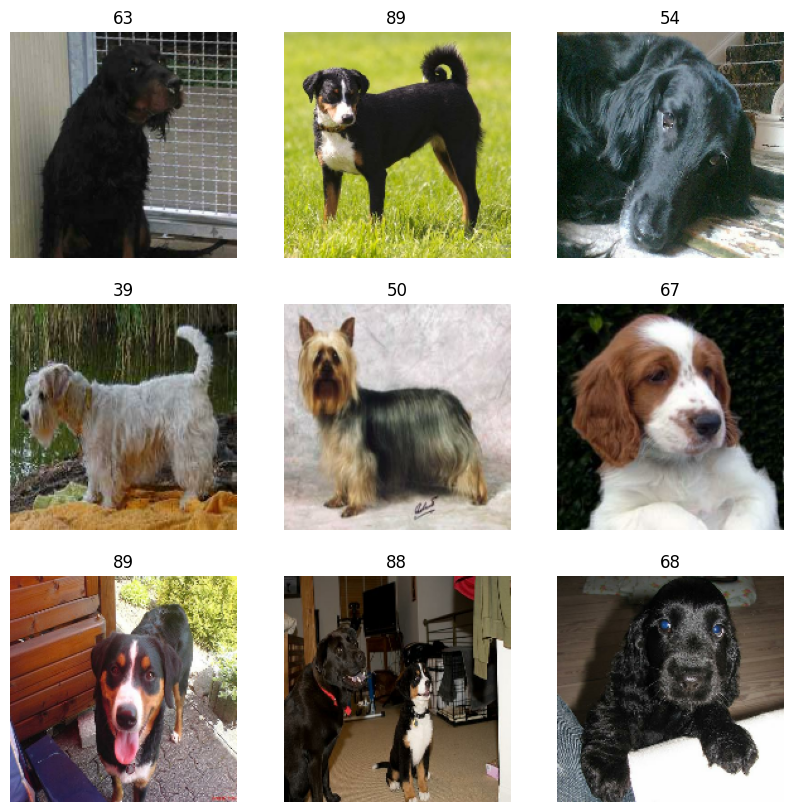

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first image in the dataset:

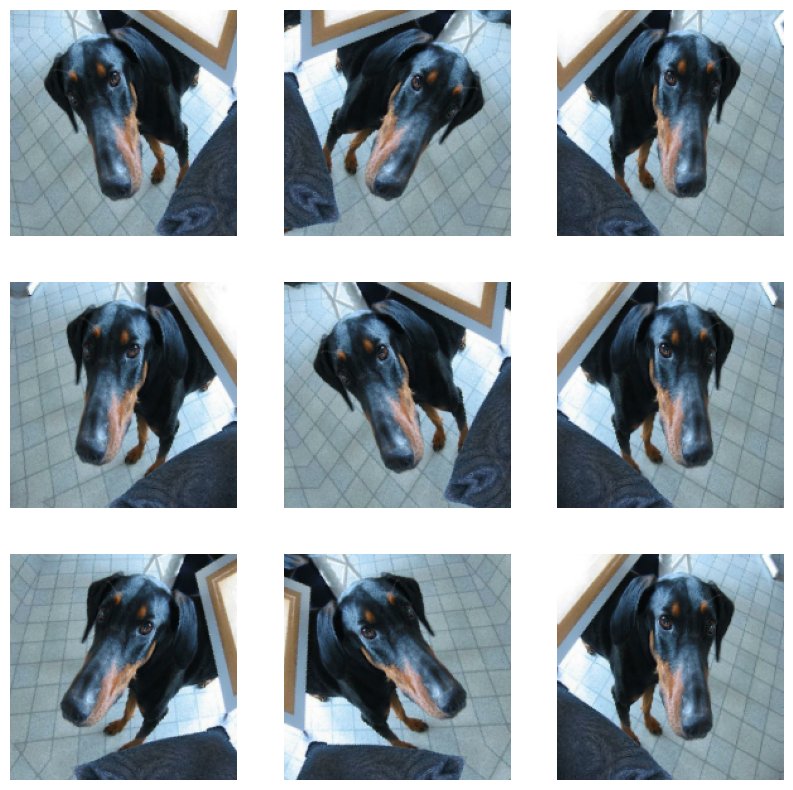

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset,
and let's make sure to use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:

In [3]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

'''
Next, the num_parallel_calls argument is set to tf.data.AUTOTUNE during the map() operation.
This allows TensorFlow to automatically determine the optimal number of parallel calls for mapping the function to the dataset,
which can help improve the performance and efficiency of the data loading pipeline.

'''
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

'''
By prefetching data in advance and keeping the GPU busy with computation, the model can efficiently process batches of data without
waiting for data loading operations to complete, which can lead to improved training performance. It is a best practice to use tf.data.AUTOTUNE
as the buffer size in the prefetch() function, as it allows TensorFlow to dynamically adapt to the system conditions and optimize the data
loading pipeline for efficient training of deep learning models.


The tf.data.AUTOTUNE argument is used as the buffer size for the prefetch() function.
tf.data.AUTOTUNE is a special value that allows TensorFlow to dynamically determine the optimal buffer size based on various factors,
such as the available system resources (e.g., CPU, memory, I/O), the dataset size, and the model's computational requirements.
Using tf.data.AUTOTUNE allows TensorFlow to automatically adjust the buffer size during training to optimize the data loading pipeline
and maximize the utilization of system resources.'''

"\nBy prefetching data in advance and keeping the GPU busy with computation, the model can efficiently process batches of data without \nwaiting for data loading operations to complete, which can lead to improved training performance. It is a best practice to use tf.data.AUTOTUNE \nas the buffer size in the prefetch() function, as it allows TensorFlow to dynamically adapt to the system conditions and optimize the data \nloading pipeline for efficient training of deep learning models.\n\n\nthe tf.data.AUTOTUNE argument is used as the buffer size for the prefetch() function. \ntf.data.AUTOTUNE is a special value that allows TensorFlow to dynamically determine the optimal buffer size based on various factors,\nsuch as the available system resources (e.g., CPU, memory, I/O), the dataset size, and the model's computational requirements. \nUsing tf.data.AUTOTUNE allows TensorFlow to automatically adjust the buffer size during training to optimize the data loading pipeline \nand maximize the 

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

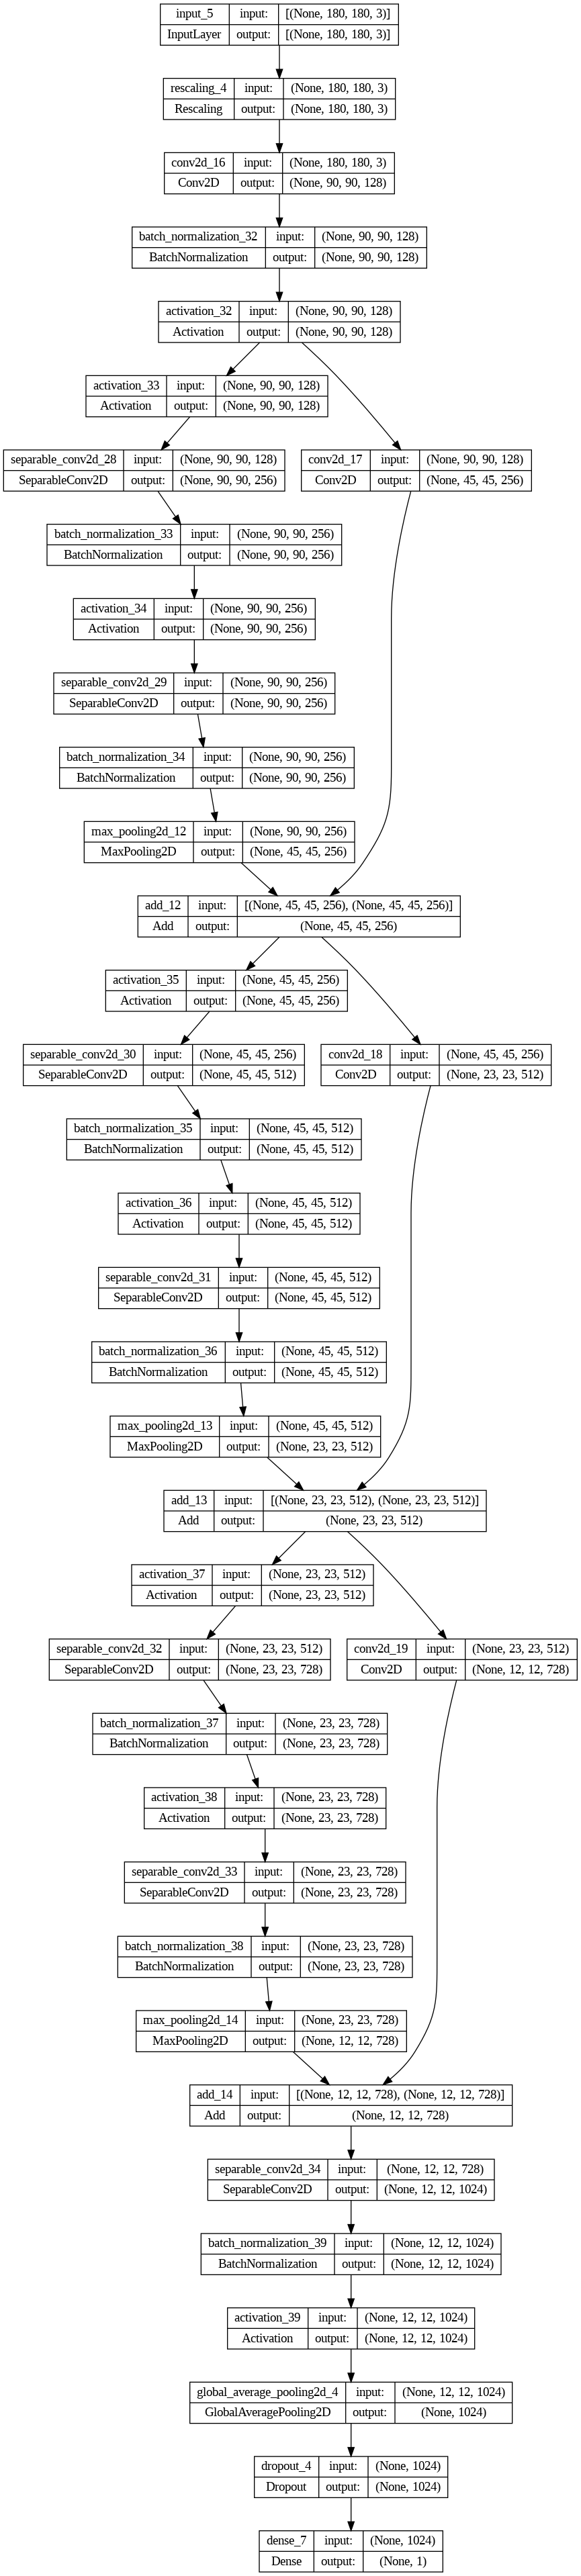

In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    # with 128 filters, a kernel size of 3x3, a stride of 2 in both the height and width dimensions, and "same" padding.
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=1)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:

#model.summary()

## Train the model

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)



Epoch 1/25
129/129 [==============================] - 38s 220ms/step - loss: -1071.6139 - accuracy: 0.0095 - val_loss: -269.1917 - val_accuracy: 0.0070
Epoch 2/25
129/129 [==============================] - 28s 211ms/step - loss: -1423.2384 - accuracy: 0.0095 - val_loss: -746.5620 - val_accuracy: 0.0070
Epoch 3/25
129/129 [==============================] - 28s 212ms/step - loss: -1831.0857 - accuracy: 0.0095 - val_loss: -1755.6581 - val_accuracy: 0.0070
Epoch 4/25
129/129 [==============================] - 28s 211ms/step - loss: -2291.6892 - accuracy: 0.0095 - val_loss: -2617.8750 - val_accuracy: 0.0070
Epoch 5/25
129/129 [==============================] - 28s 211ms/step - loss: -2793.6074 - accuracy: 0.0095 - val_loss: -3164.3308 - val_accuracy: 0.0070
Epoch 6/25
129/129 [==============================] - 28s 211ms/step - loss: -3353.7749 - accuracy: 0.0095 - val_loss: -3956.9229 - val_accuracy: 0.0070
Epoch 7/25
129/129 [==============================] - 28s 211ms/step - loss: -3980.8

In [ ]:
model.save('/content/drive/MyDrive/data/trained_modelRE1.h5')

# Experiment 2:
## Load the saved model and replace only the output layer of the model (to align it to the new problem). When this is done, train and evaluate the model (for 50 epochs) on the cats and dogs dataset.

In [18]:
!pwd

/content/drive/MyDrive/data


In [28]:
#!/bin/bash
!curl -L -o kagglecatsanddogs_3367a.zip\
  https://www.kaggle.com/api/v1/datasets/download/karakaggle/kaggle-cat-vs-dog-dataset



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  787M  100  787M    0     0  84.3M      0  0:00:09  0:00:09 --:--:-- 85.3M


In [29]:
!ls

Images	images.tar  kagglecatsanddogs_3367a.zip


In [30]:
!unzip -q kagglecatsanddogs_3367a.zip

clean corrupted images from cats and dogs file

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds2, val_ds2 = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23439 files belonging to 2 classes.
Using 18752 files for training.
Using 4687 files for validation.


In [ ]:
# Apply `data_augmentation` to the training images.
train_ds2 = train_ds2.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds2 = train_ds2.prefetch(tf.data.AUTOTUNE)
val_ds2 = val_ds2.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Load the model
model1 = keras.models.load_model('trained_modelRE1.h5')

# Remove the last layer
new_model_layers = model1.layers[:-1]

# Create a new output layer
num_classes = 2
if num_classes == 2:
    activation = "sigmoid"
    units = 1
else:
    activation = "softmax"
    units = num_classes

new_output_layer = layers.Dense(units, activation=activation)(new_model_layers[-1].output)

# Create the new model with the modified architecture
model_second = keras.Model(inputs=model1.input, outputs=new_output_layer)



In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model_second.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_second.fit(
    train_ds2,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds2,
)


Epoch 1/50
147/147 [==============================] - 52s 229ms/step - loss: 0.7416 - accuracy: 0.5863 - val_loss: 0.6664 - val_accuracy: 0.6081
Epoch 2/50
147/147 [==============================] - 31s 204ms/step - loss: 0.6301 - accuracy: 0.6732 - val_loss: 0.8346 - val_accuracy: 0.5377
Epoch 3/50
147/147 [==============================] - 31s 204ms/step - loss: 0.5924 - accuracy: 0.7050 - val_loss: 0.5143 - val_accuracy: 0.7493
Epoch 4/50
147/147 [==============================] - 31s 204ms/step - loss: 0.5566 - accuracy: 0.7295 - val_loss: 0.6835 - val_accuracy: 0.6514
Epoch 5/50
147/147 [==============================] - 31s 204ms/step - loss: 0.5253 - accuracy: 0.7502 - val_loss: 0.5676 - val_accuracy: 0.7167
Epoch 6/50
147/147 [==============================] - 31s 204ms/step - loss: 0.5030 - accuracy: 0.7632 - val_loss: 0.5261 - val_accuracy: 0.7389
Epoch 7/50
147/147 [==============================] - 31s 204ms/step - loss: 0.4848 - accuracy: 0.7766 - val_loss: 0.4781 - val_ac

# Save the model

In [ ]:
model_second.save('/content/drive/MyDrive/data/model_secondRE2.h5')

# Test model

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions1 = model_second.predict(img_array)
score1 = float(predictions1[0])
print(f"This image is {100 * (1 - score1):.2f}% cat and {100 * score1:.2f}% dog.")

1/1 [==============================] - 0s 340ms/step
This image is 99.96% cat and 0.04% dog.


# Experiment 3:
## Load the saved model and replace the output layer of the model, as well as the first two convolutional layers (keep the weights of all other layers). Train and evaluate the model on the cats and dogs dataset when this is done.

In [ ]:

#model3.summary()

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

model3 = keras.models.load_model("model_secondRE2.h5")

# Remove the output layer
new_model_layers2 = model3.layers[:-1]

# Find the indices of the first two convolutional layers
conv_layers = []
for layer in model3.layers:
    if isinstance(layer, Conv2D):
        conv_layers.append(layer)
        if len(conv_layers) == 2:
            break

conv1_index = model3.layers.index(conv_layers[0])
conv2_index = model3.layers.index(conv_layers[1])

# Freeze layers before the first convolution layer
for layer in new_model_layers2[:conv1_index]:
    layer.trainable = False

# Replace the first convolutional layer
new_conv1_layer = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(new_model_layers2[conv1_index-1].output)
new_model_layers2[conv1_index] = new_conv1_layer

# Freeze layers between the first and second convolution layers
for layer in new_model_layers2[conv1_index+1:conv2_index]:
    layer.trainable = False

# Replace the second convolutional layer
new_conv2_layer = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(new_model_layers2[conv2_index].output)
new_model_layers2[conv2_index] = new_conv2_layer

# Freeze layers after the second convolution layer
for layer in new_model_layers2[conv2_index+1:]:
    layer.trainable = False

# Add a new output layer with the desired number of units and activation function
num_classes = 2

if num_classes == 2:
    activation = "sigmoid"
    units = 1
else:
    activation = "softmax"
    units = num_classes

new_output_layer = layers.Dense(units, activation=activation)(new_model_layers2[-1].output)
model_third = keras.Model(inputs=model3.input, outputs=new_output_layer)

epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model_third.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model_third.fit(
    train_ds2,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds2,
)


Epoch 1/50
147/147 [==============================] - 29s 173ms/step - loss: 0.4291 - accuracy: 0.7951 - val_loss: 0.2030 - val_accuracy: 0.9232
Epoch 2/50
147/147 [==============================] - 26s 169ms/step - loss: 0.1718 - accuracy: 0.9367 - val_loss: 0.1718 - val_accuracy: 0.9307
Epoch 3/50
147/147 [==============================] - 26s 169ms/step - loss: 0.1434 - accuracy: 0.9479 - val_loss: 0.1740 - val_accuracy: 0.9287
Epoch 4/50
147/147 [==============================] - 26s 170ms/step - loss: 0.1269 - accuracy: 0.9515 - val_loss: 0.1708 - val_accuracy: 0.9302
Epoch 5/50
147/147 [==============================] - 26s 170ms/step - loss: 0.1191 - accuracy: 0.9553 - val_loss: 0.1708 - val_accuracy: 0.9311
Epoch 6/50
147/147 [==============================] - 26s 169ms/step - loss: 0.1121 - accuracy: 0.9565 - val_loss: 0.1696 - val_accuracy: 0.9313
Epoch 7/50
147/147 [==============================] - 26s 169ms/step - loss: 0.1061 - accuracy: 0.9593 - val_loss: 0.1697 - val_ac

# Save the model

In [ ]:
model_third.save('model_thirdRE3.h5')

# Test Model

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions2 = model_third.predict(img_array)
score2 = float(predictions2[0])
print(f"This image is {100 * (1 - score2):.2f}% cat and {100 * score2:.2f}% dog.")

1/1 [==============================] - 0s 23ms/step
This image is 100.00% cat and 0.00% dog.


# Experiment 4:
## Load the saved model and replace the output layer of the model, as well as the two last convolutional layers. Train and evaluate the model on the cats and dogs dataset when this is done.

In [ ]:
model4 = keras.models.load_model('model_thirdRE3.h5')
#model4.summary()

In [ ]:

# Remove the output layer
new_model_layers3 = model4.layers[:-1]

# Find the indices of the last two convolutional layers
conv_layers = []
for layer in reversed(model4.layers):
    if isinstance(layer, Conv2D):
        conv_layers.append(layer)
        if len(conv_layers) == 2:
            break

conv2_index = model4.layers.index(conv_layers[0])
conv1_index = model4.layers.index(conv_layers[1])

# Freeze layers before the first convolution layer
for layer in new_model_layers3[:conv1_index]:
    layer.trainable = False

# Replace the first convolutional layer
new_conv1_layer1 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(new_model_layers3[conv1_index].output)
new_model_layers3[conv1_index] = new_conv1_layer1
# Freeze layers between the first and second convolution layers
for layer in new_model_layers3[conv1_index+1:conv2_index]:
    layer.trainable = False

# Replace the second convolutional layer
new_conv2_layer1 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(new_model_layers3[conv2_index].output)
new_model_layers3[conv2_index] = new_conv2_layer1
# Freeze layers after the second convolution layer
for layer in new_model_layers3[conv2_index+1:]:
    layer.trainable = False

# Add a new output layer with the desired number of units and activation function
num_classes = 2

if num_classes == 2:
    activation = "sigmoid"
    units = 1
else:
    activation = "softmax"
    units = num_classes

new_output_layer = layers.Dense(units, activation=activation)(new_model_layers3[-1].output)
model_forth = keras.Model(inputs=model4.input, outputs=new_output_layer)

epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model_forth.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model_forth.fit(
    train_ds2,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds2,
)


Epoch 1/50
147/147 [==============================] - 19s 114ms/step - loss: 0.5547 - accuracy: 0.7030 - val_loss: 0.2984 - val_accuracy: 0.9281
Epoch 2/50
147/147 [==============================] - 18s 115ms/step - loss: 0.2538 - accuracy: 0.9284 - val_loss: 0.2136 - val_accuracy: 0.9309
Epoch 3/50
147/147 [==============================] - 19s 119ms/step - loss: 0.1817 - accuracy: 0.9503 - val_loss: 0.1862 - val_accuracy: 0.9326
Epoch 4/50
147/147 [==============================] - 18s 114ms/step - loss: 0.1499 - accuracy: 0.9573 - val_loss: 0.1743 - val_accuracy: 0.9330
Epoch 5/50
147/147 [==============================] - 18s 114ms/step - loss: 0.1318 - accuracy: 0.9596 - val_loss: 0.1685 - val_accuracy: 0.9319
Epoch 6/50
147/147 [==============================] - 18s 114ms/step - loss: 0.1210 - accuracy: 0.9613 - val_loss: 0.1664 - val_accuracy: 0.9326
Epoch 7/50
147/147 [==============================] - 18s 116ms/step - loss: 0.1149 - accuracy: 0.9618 - val_loss: 0.1644 - val_ac

# Save the model

In [ ]:
model_forth.save('model_forthRE4.h5')

# Test Model

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions3 = model_forth.predict(img_array)
score3 = float(predictions3[0])
print(f"This image is {100 * (1 - score3):.2f}% cat and {100 * score3:.2f}% dog.")

1/1 [==============================] - 0s 250ms/step
This image is 100.00% cat and 0.00% dog.
